In [1]:
# import statements
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xrscipy.signal.extra as dsp_extra
from scipy.ndimage import gaussian_filter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# function because some of the simulations have a messed-up calendar
def preprocess(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

def load(var: str, init_time: str, ens_num: int):
    path = "/mnt/drive2/wof-runs/"+init_time+"/"+var+"/wrfwof*.{:02d}".format(ens_num)
    return(xr.open_mfdataset(path,preprocess=preprocess,
                          decode_times=False,combine="nested",
                          concat_dim="Time")
    )
def fix_xtime(ds_in: xr.Dataset,init_time: str) -> xr.Dataset:
    if init_time in ["20", "21", "22", "23"]:
        start_date = "2021-09-01"
    elif init_time in ["00", "01", "02"]:
        start_date = "2021-09-02"
    else:
        raise ValueError("Unexpected init_time provided.")
    ds_in.XTIME.attrs["units"] = "minutes since "+start_date+" "+init_time+":00:00"
    ds_in.XTIME.attrs["description"] = ("minutes since "+start_date+" "+
                                        init_time+":00:00")
    return(xr.decode_cf(ds_in))

In [3]:
print("21Z")
mslp_21Z = xr.concat([fix_xtime(load("MSLP","21Z",e),"21") for e in range(1,19)],
                       "ens").MSLP
print("22Z")
mslp_22Z = xr.concat([fix_xtime(load("MSLP","22Z",e),"22") for e in range(1,19)],
                       "ens").MSLP
print("23Z")
mslp_23Z = xr.concat([fix_xtime(load("MSLP","23Z",e),"23") for e in range(1,19)],
                       "ens").MSLP
print("00Z")
mslp_00Z = xr.concat([fix_xtime(load("MSLP","00Z",e),"00") for e in range(1,19)],
                       "ens").MSLP

21Z
22Z
23Z
00Z


In [4]:
def get_time(ds_in: xr.DataArray, time: str) -> xr.DataArray:
    return(ds_in.isel(Time=abs(ds_in.XTIME - np.datetime64(
        pd.to_datetime(time))).argmin()))

In [5]:
lat = mslp_21Z.XLAT.isel(Time=0)
lon = mslp_21Z.XLONG.isel(Time=0)

In [6]:
# get central latitude and longitude for projections
central_latitude = float(lat.mean())
central_longitude = float(lon.mean())

mslp_list = [
    mslp_21Z,mslp_22Z,mslp_23Z,mslp_00Z
    ]

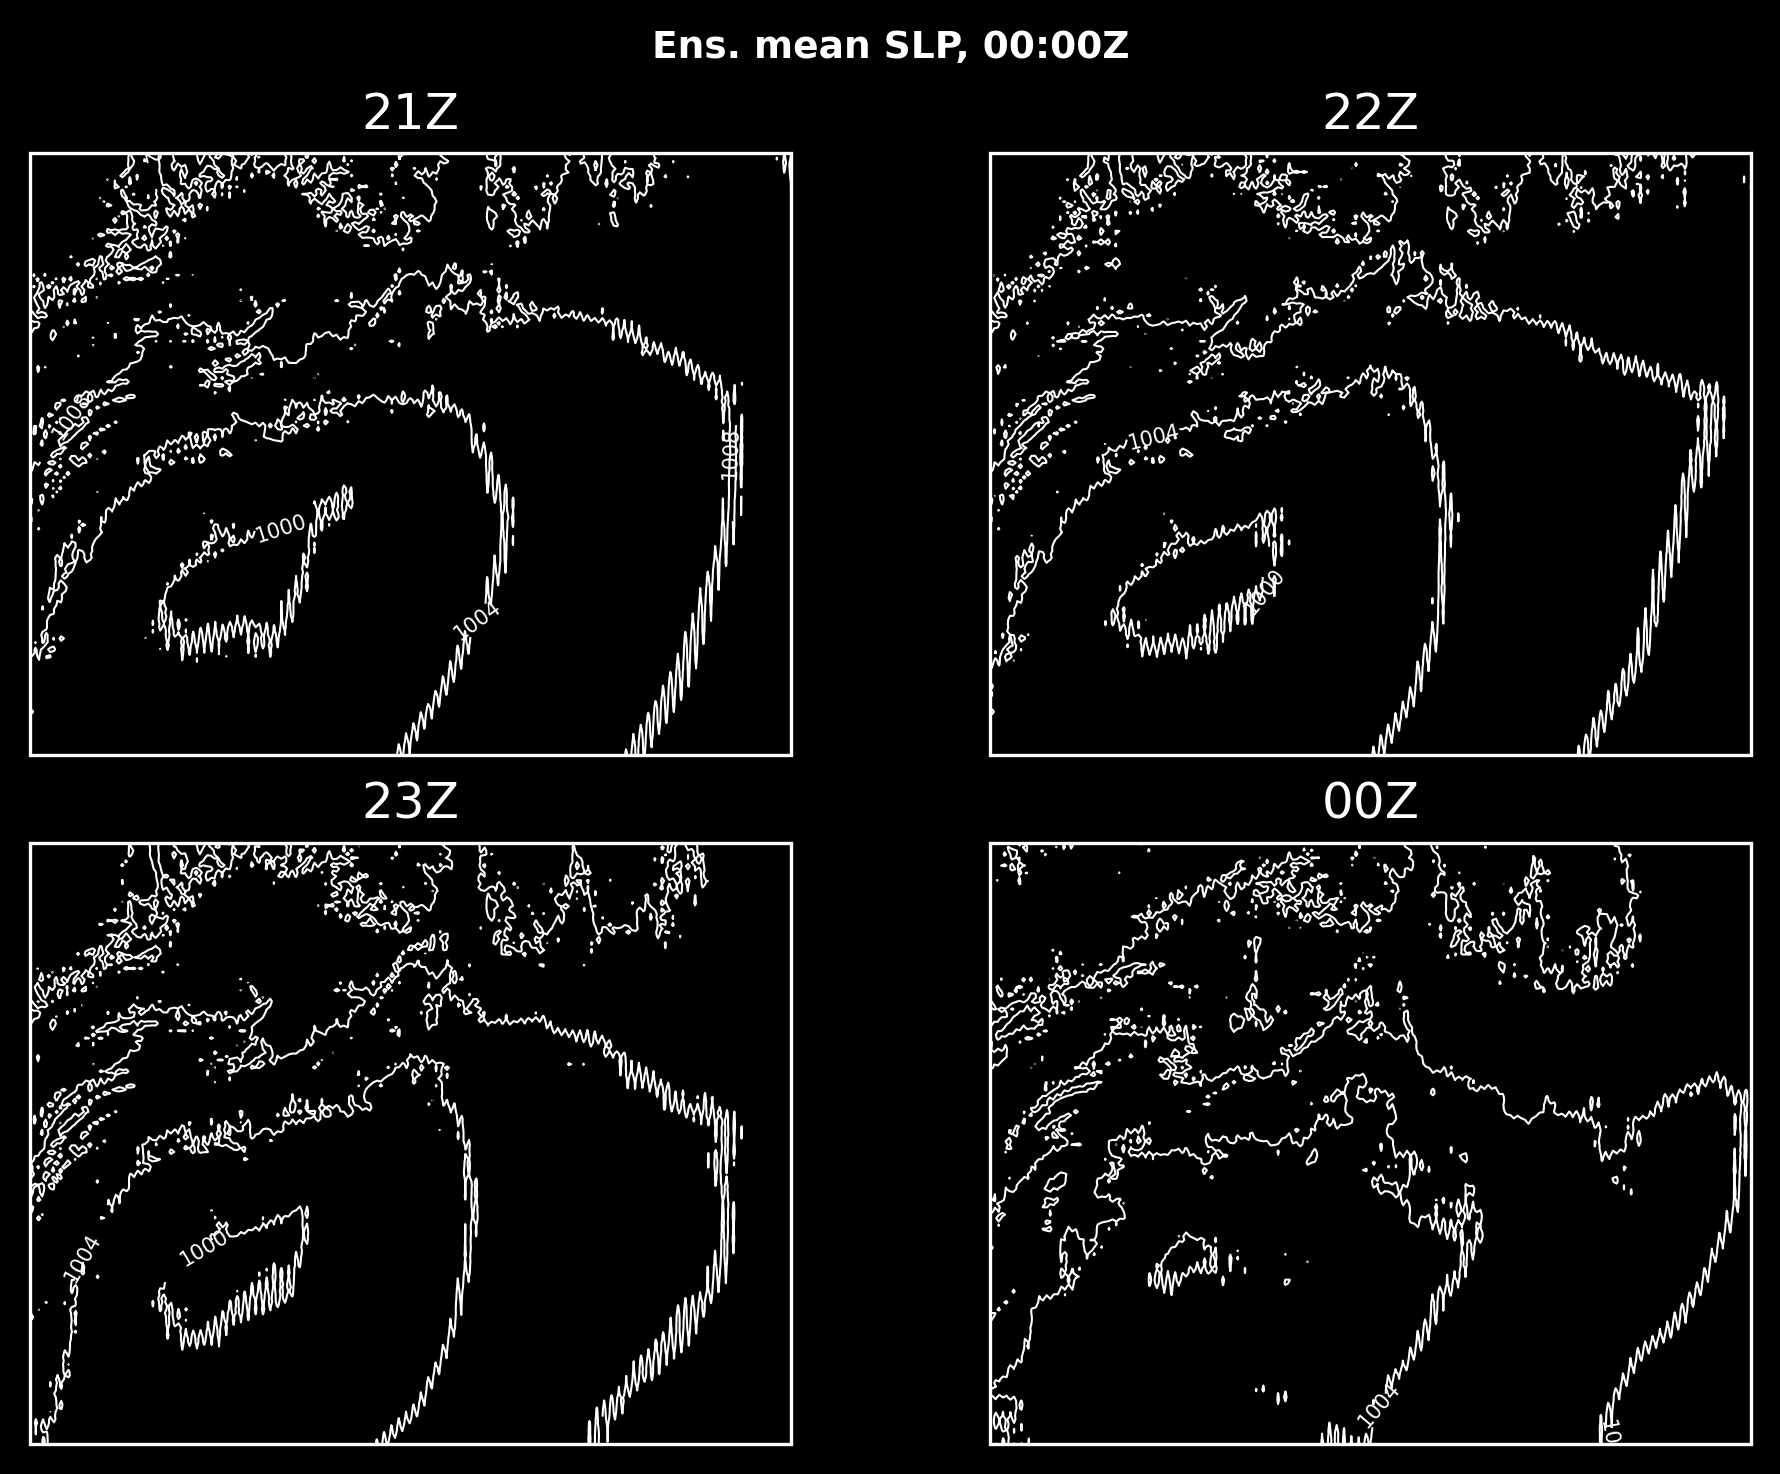

In [7]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:00:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

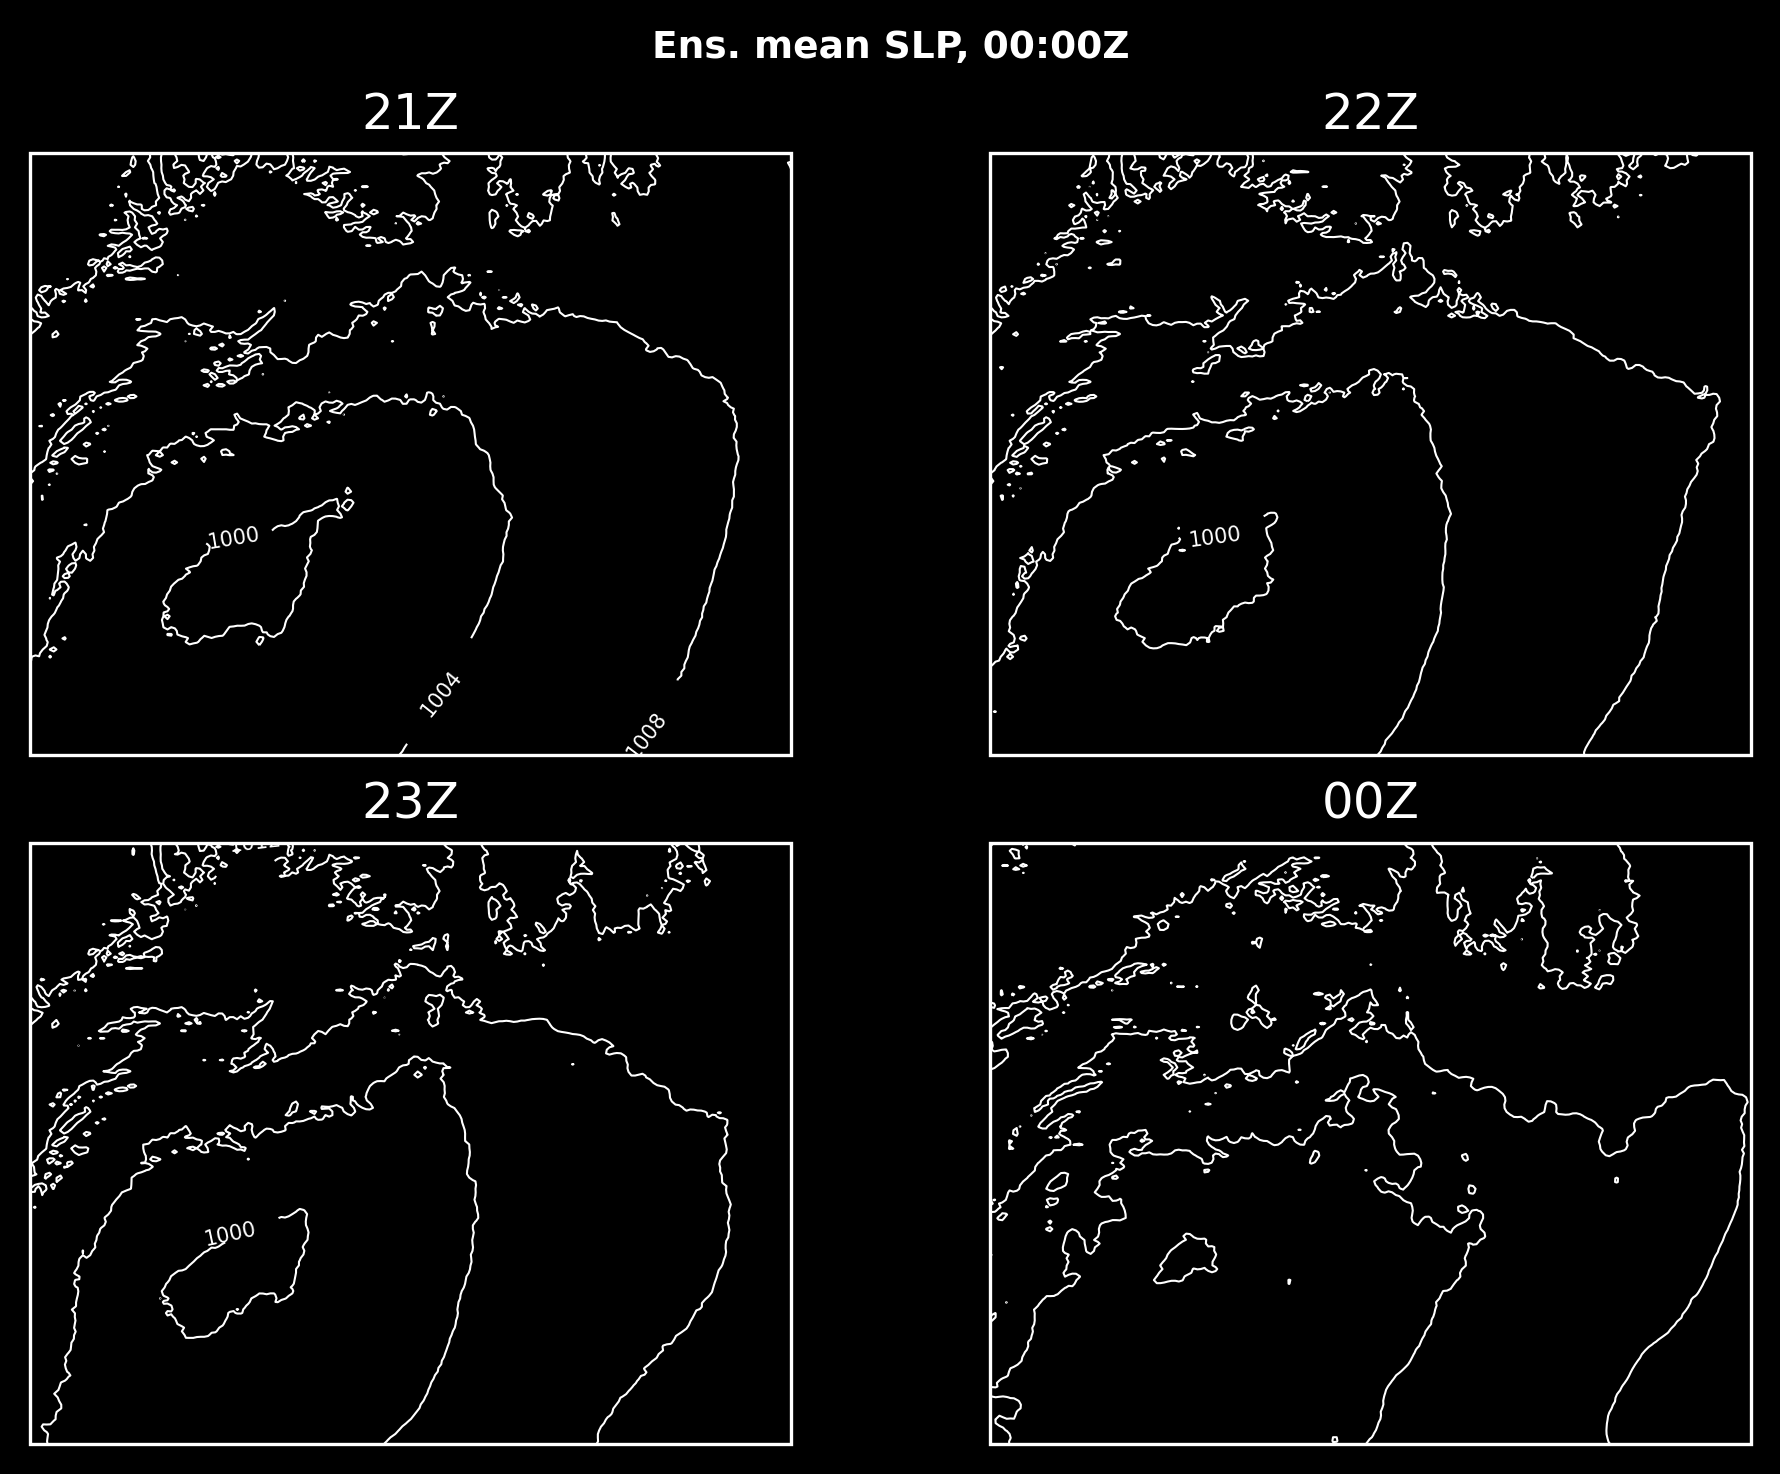

In [61]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [d.rolling(west_east=2,center=True).mean() 
                for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

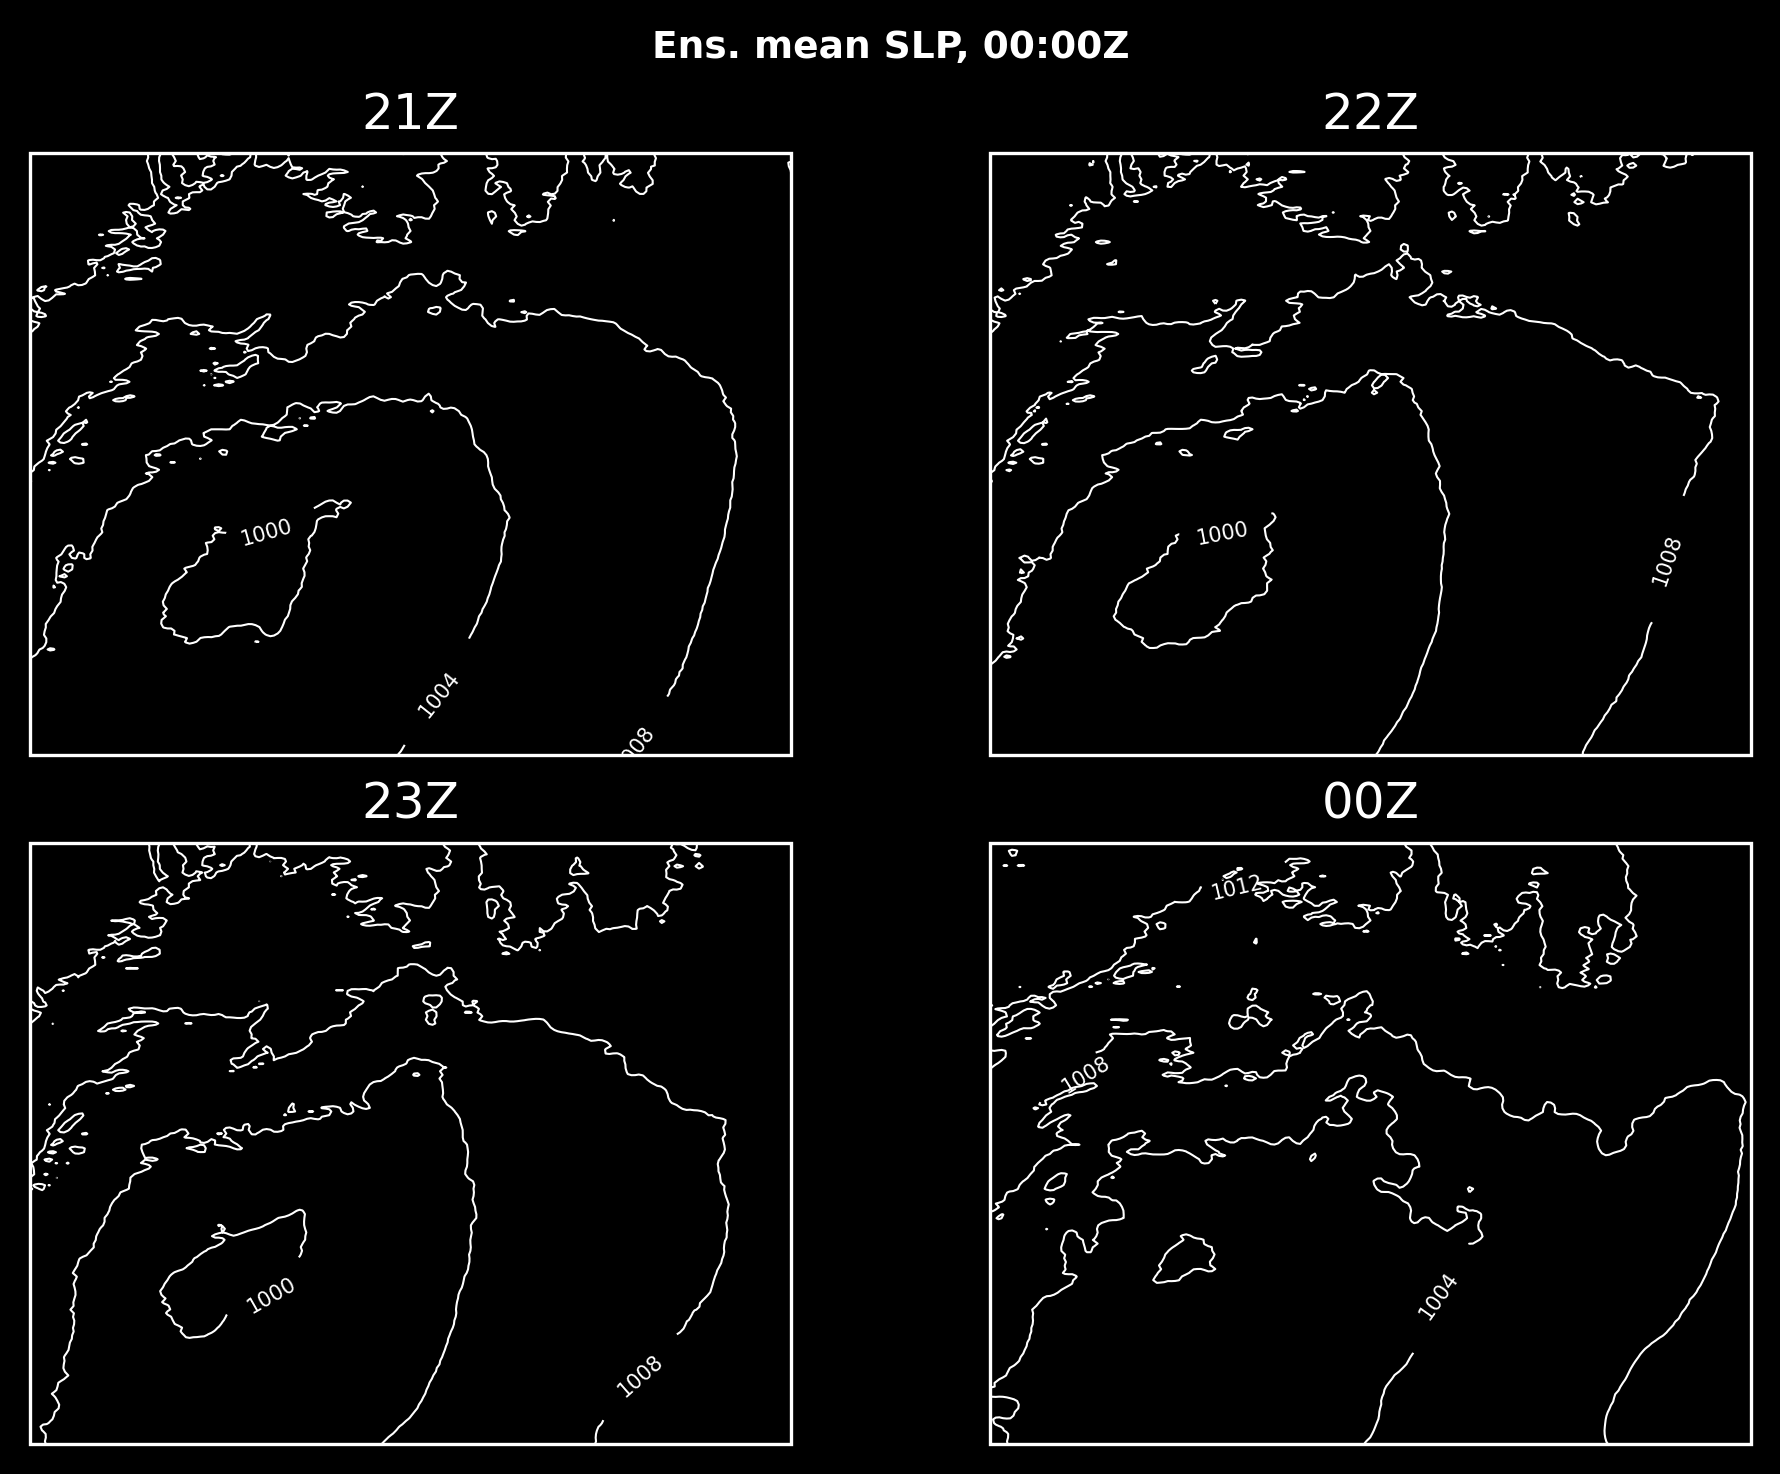

In [64]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [d.to_dataset().apply(gaussian_filter, sigma=sigma, axes=1) 
                for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i].MSLP/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

In [9]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [dsp_extra.lowpass(d.load(),f_cutoff=0.3,dim="west_east")
                         for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z, lowpass filter",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

TypeError: unhashable type: 'list'

In [20]:
# Let's see if we can get all the smoothing methods on one plot

# First is unsmoothed
unsmoothed = [get_time(m,"2021-09-02 01:00:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]
averaged = [u.rolling(west_east=2,center=True).mean() 
                for u in unsmoothed]
gaussian = [u.to_dataset().apply(gaussian_filter, sigma=1.6, axes=[0,1]).MSLP 
                for u in unsmoothed]
lowpass = [dsp_extra.lowpass(u.load(),f_cutoff=0.3,dim="west_east")
                         for u in unsmoothed]
evens = [u.isel(west_east = slice(None,None,2)) for u in unsmoothed]
odds = [u.isel(west_east = slice(1,None,2)) for u in unsmoothed]

evens_lons = evens[0].XLONG
evens_lats = evens[0].XLAT

odds_lons = odds[0].XLONG
odds_lats = odds[0].XLAT


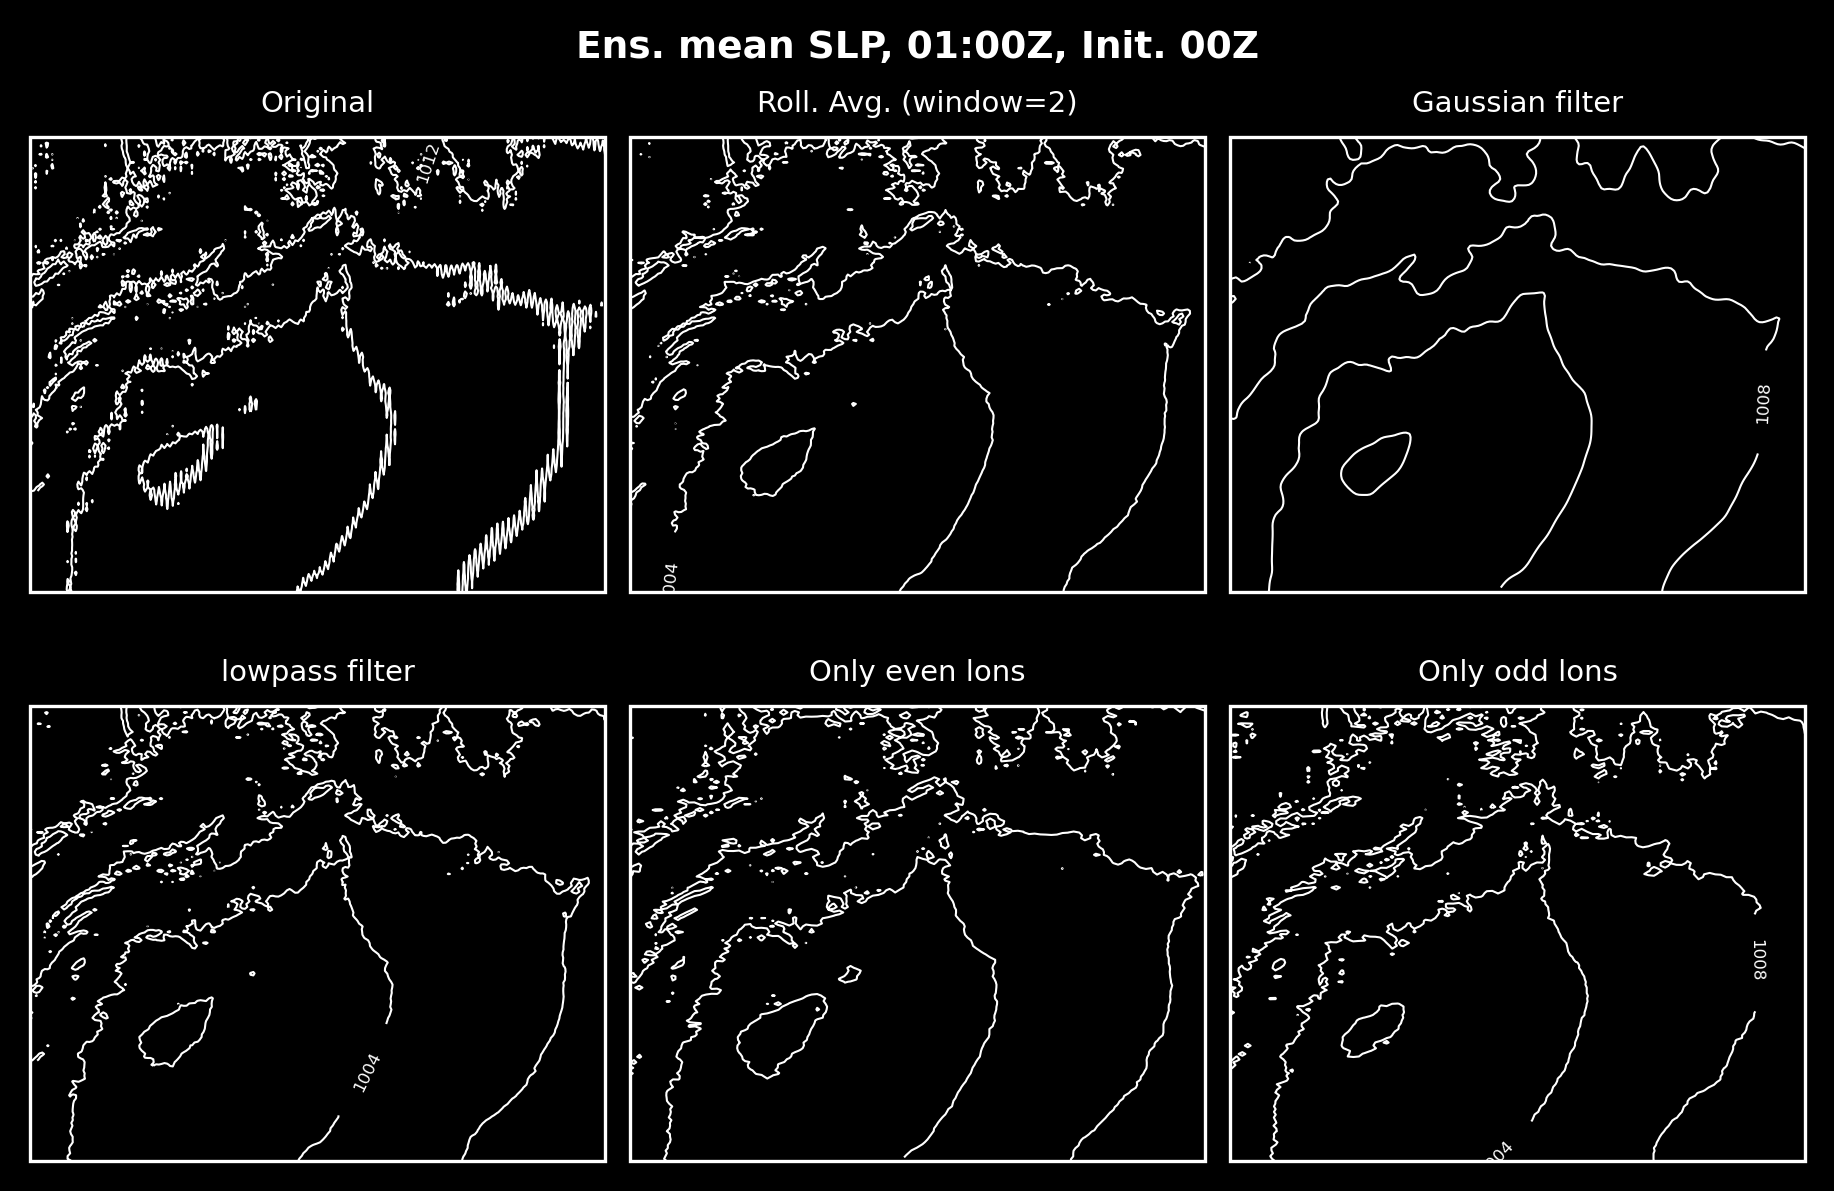

In [21]:
# Plot 'em up!
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["Original", "Roll. Avg. (window=2)", "Gaussian filter", "lowpass filter",
          "Only even lons","Only odd lons"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot = [ds[3] for ds in [unsmoothed,averaged,gaussian,lowpass,
                                 evens,odds]]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,4))

for i,ax in enumerate(axes.flatten()):
    if(i<4):
        c = ax.contour(
            lon,lat,data_to_plot[i]/100,
            transform=ccrs.PlateCarree(),
            colors="white",
            levels=np.arange(996,1025,4),
            linewidths=0.5
        )
    elif(i==4):
            c = ax.contour(
            evens_lons,evens_lats,data_to_plot[i]/100,
            transform=ccrs.PlateCarree(),
            colors="white",
            levels=np.arange(996,1025,4),
            linewidths=0.5
        )
    elif(i==5):
            c = ax.contour(
            odds_lons,odds_lats,data_to_plot[i]/100,
            transform=ccrs.PlateCarree(),
            colors="white",
            levels=np.arange(996,1025,4),
            linewidths=0.5
        )
            
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i],fontsize=7)

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 01:00Z, Init. 00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

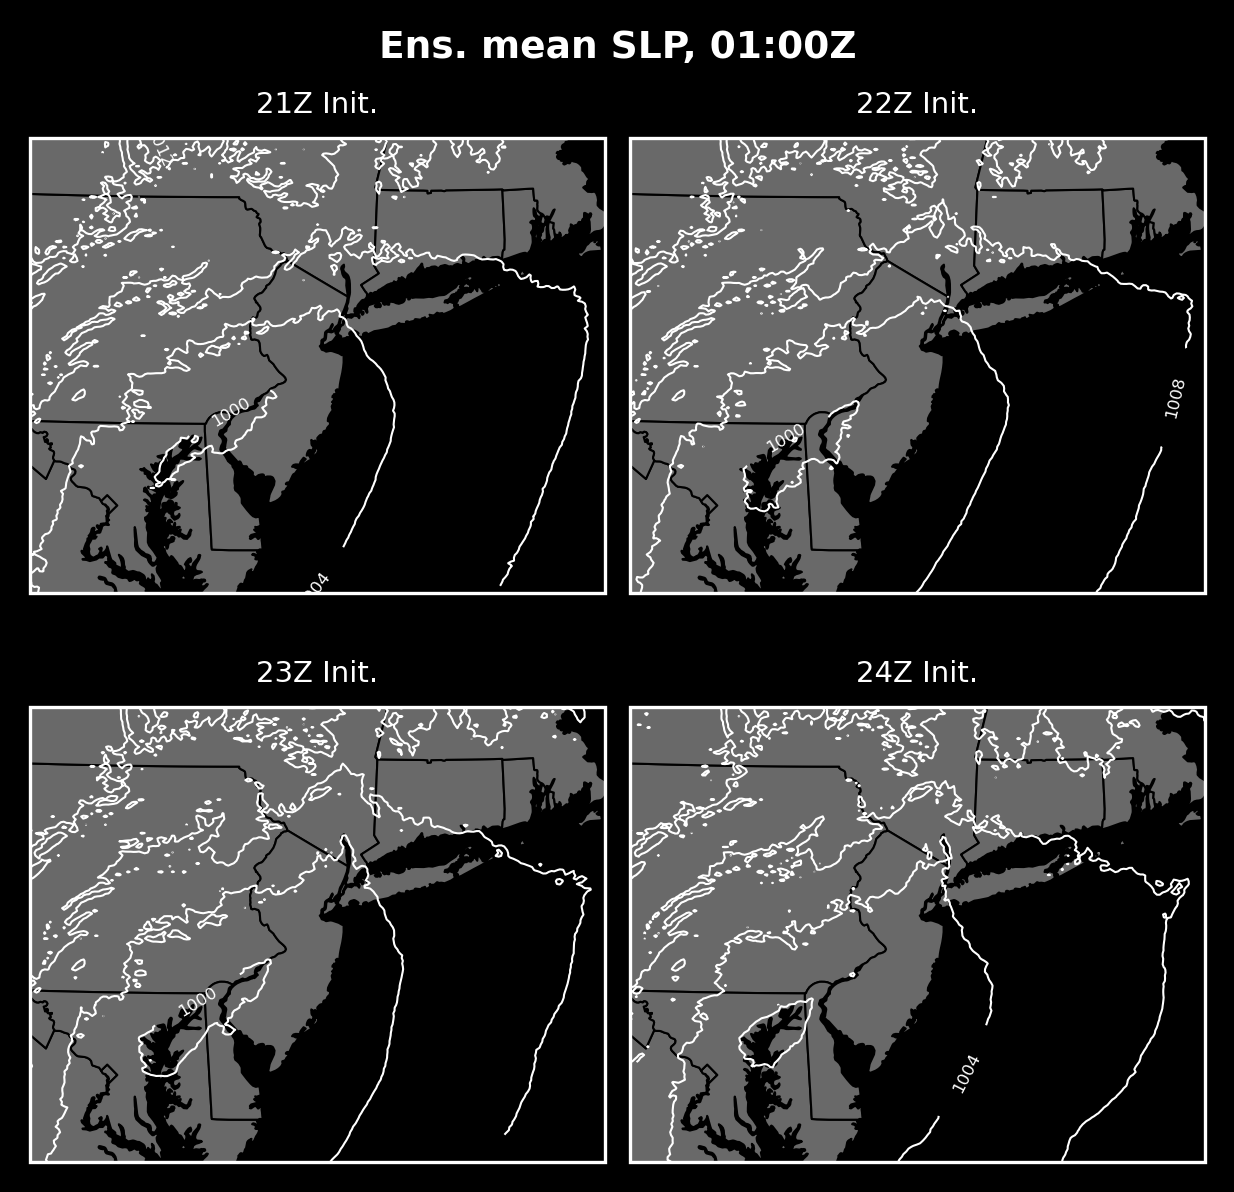

In [16]:
# Plot 'em up!
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z Init.","22Z Init.","23Z Init.","24Z Init."]

plt.style.use("dark_background")

# Get data to plot
data_to_plot = lowpass

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(4,4))

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
            
    ax.clabel(c,c.levels,inline=True,fontsize=4)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth,facecolor="dimgray",
                       edgecolor="black")
    ax.set_title(titles[i],fontsize=7)

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 01:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()